# Präsenzversuch zum Laval-Rotor

Name: Keanu Engel
Datum: 06.02.2024
Gruppe: 12

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Wie kann man die Schwingungen/ Vibrationen während des Lavalrotor-Versuchs messen, die man während des Versuchs wahrnehmen konnte und passen diese dann zu den gezeigten Ergebnissen in dem Campbell-Diagramm? Passen die kritischen Bereiche im Campbell-Diagramm zu der vorher bestimmten kritischen Drehzahl des Prüfstandaufbaus?

## Erster Versuch: Prüfstand #03
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/Prüfstand_03_labor_laval_rotor.jpg" width="800">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Bei diesem Versuch wurde ein Laval-Rotor Prüfstand an ein Raspberry-Pi angeschlossen. Der Prüfstand besteht aus einem Schaltkasten, der an einen Motor angeschlossen ist. Zwischen Schaltkasten und Motor befindet sich ein Drehzahlsensor der die Echtzeit Drehzahldaten an den Raspberry-Pi übergibt. An dem Motor ist eine Welle befestigt, die 0,75 m lang und einen Durchmesser von 10 mm hat. Diese Welle ist auf der linken Seite mit einem Loslager und auf der rechten Seite mit einem Festlager gelagert. Auf diesem Festlager ist der Beschleunigungssensor befestigt, der die Messdaten aufnimmt. In der Mitte befindet sich ein Fanglager, an dessen Seite sich eine einzige Scheibe befindet, die 950 g schwer ist, 15 mm dick und einen Durchmesser von 99 mm hat.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240123_140859_lavalrotor_12_03'
)  # path to the folder with H5-file and metadata
filename = 'data_20240123_140859_lavalrotor_12_03.h5'  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240123_140859_lavalrotor_12_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
# Initialize data structures for the Campbell diagram
time = []
rpm = []
amplitude_fft =[]
frequency_fft = [] 

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

# path to the h5 data
h5_path = f"{path_measurement_folder}/{filename}"

# Loop to read out the data
with h5py.File(h5_path) as f:
    for i in f.keys():
        group_h5 = f[i]["RawData"]

        acc_x_value = np.array(group_h5[uuid_acceleration]["acceleration_x"])
        acc_y_value= np.array(group_h5[uuid_acceleration]["acceleration_y"])
        acc_z_value = np.array(group_h5[uuid_acceleration]["acceleration_z"])
        time_value = np.array(group_h5[uuid_acceleration]["timestamp"])
        time.append(time_value)
        rpm_value = group_h5[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_value)

        # calculate the absolute acceleration
        acc_data_value = m_postprocessing.get_vec_accel(acc_x_value, acc_y_value, acc_z_value)

        # interpolate the acceleration data to get the amplitudes and frequencies
        interpolated_acc_data_value = m_postprocessing.interpolation(time_value, acc_data_value, interpolation_points)
        amplitude_fft_value, frequency_fft_value = m_postprocessing.my_fft_scaled(interpolated_acc_data_value, interpolation_points)
        amplitude_fft.append(amplitude_fft_value[1:])
        frequency_fft.append(frequency_fft_value[1:])

#print(amplitude_fft)        

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

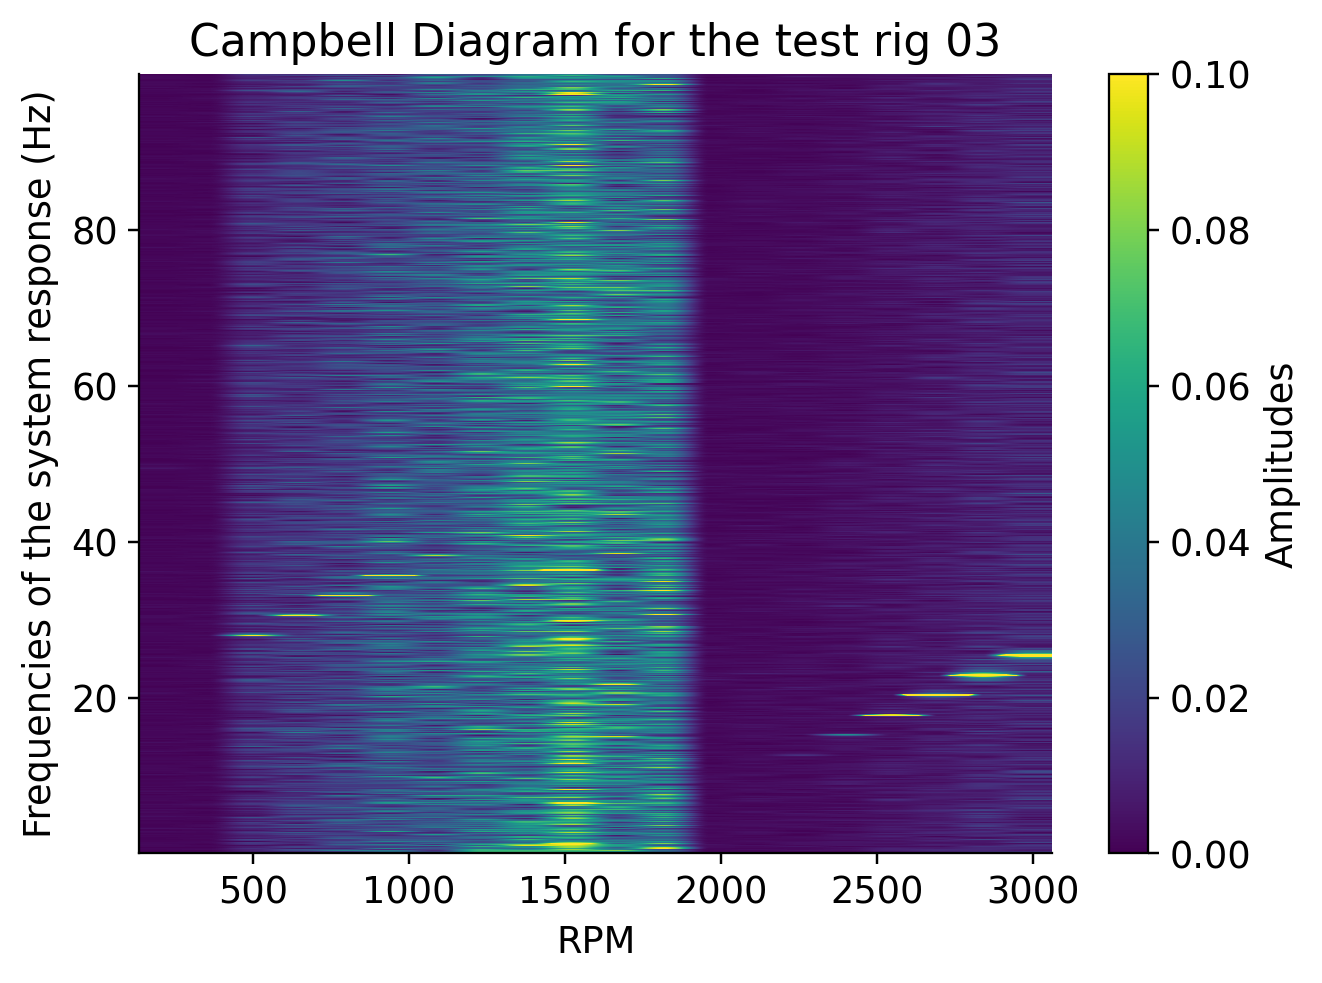

In [7]:
# create the Heatmap (Campbell-Diagramm)
plt.imshow(np.transpose(amplitude_fft), extent=[np.min(rpm), np.max(rpm), np.min(frequency_fft), np.max(frequency_fft)],
           aspect='auto', cmap='viridis', origin='lower', vmin=0, vmax=0.1)
plt.colorbar(label='Amplitudes')
plt.xlabel('RPM')
plt.ylabel('Frequencies of the system response (Hz)')
plt.title('Campbell Diagram for the test rig 03')
plt.show()

## Zweiter Datensatz: Prüfstand #02

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240102_100928_lavalrotor_01_02'
)  # path to the folder with H5-file and metadata
filename = 'data_20240102_100928_lavalrotor_01_02.h5'  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)  # reload functions

time = []
rpm = []
amplitude_fft =[]
frequency_fft = []

# path to the h5 data
h5_path = f"{path_measurement_folder}/{filename}"

# Loop to read out the data
with h5py.File(h5_path) as f:
    for i in f.keys():
        group_h5 = f[i]["RawData"]

        acc_x_value = np.array(group_h5[uuid_acceleration]["acceleration_x"])
        acc_y_value= np.array(group_h5[uuid_acceleration]["acceleration_y"])
        acc_z_value = np.array(group_h5[uuid_acceleration]["acceleration_z"])
        time_value = np.array(group_h5[uuid_acceleration]["timestamp"])
        time.append(time_value)
        rpm_value = group_h5[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_value)

        # calculate the absolute acceleration
        acc_data_value = m_postprocessing.get_vec_accel(acc_x_value, acc_y_value, acc_z_value)

        # interpolate the acceleration data to get the amplitudes and frequencies
        interpolated_acc_data_value = m_postprocessing.interpolation(time_value, acc_data_value, interpolation_points)
        amplitude_fft_value, frequency_fft_value = m_postprocessing.my_fft_scaled(interpolated_acc_data_value, interpolation_points)
        amplitude_fft.append(amplitude_fft_value[1:])
        frequency_fft.append(frequency_fft_value[1:])

#print(amplitude_fft)

#### 3. Darstellung mittels Campbell-Diagramm

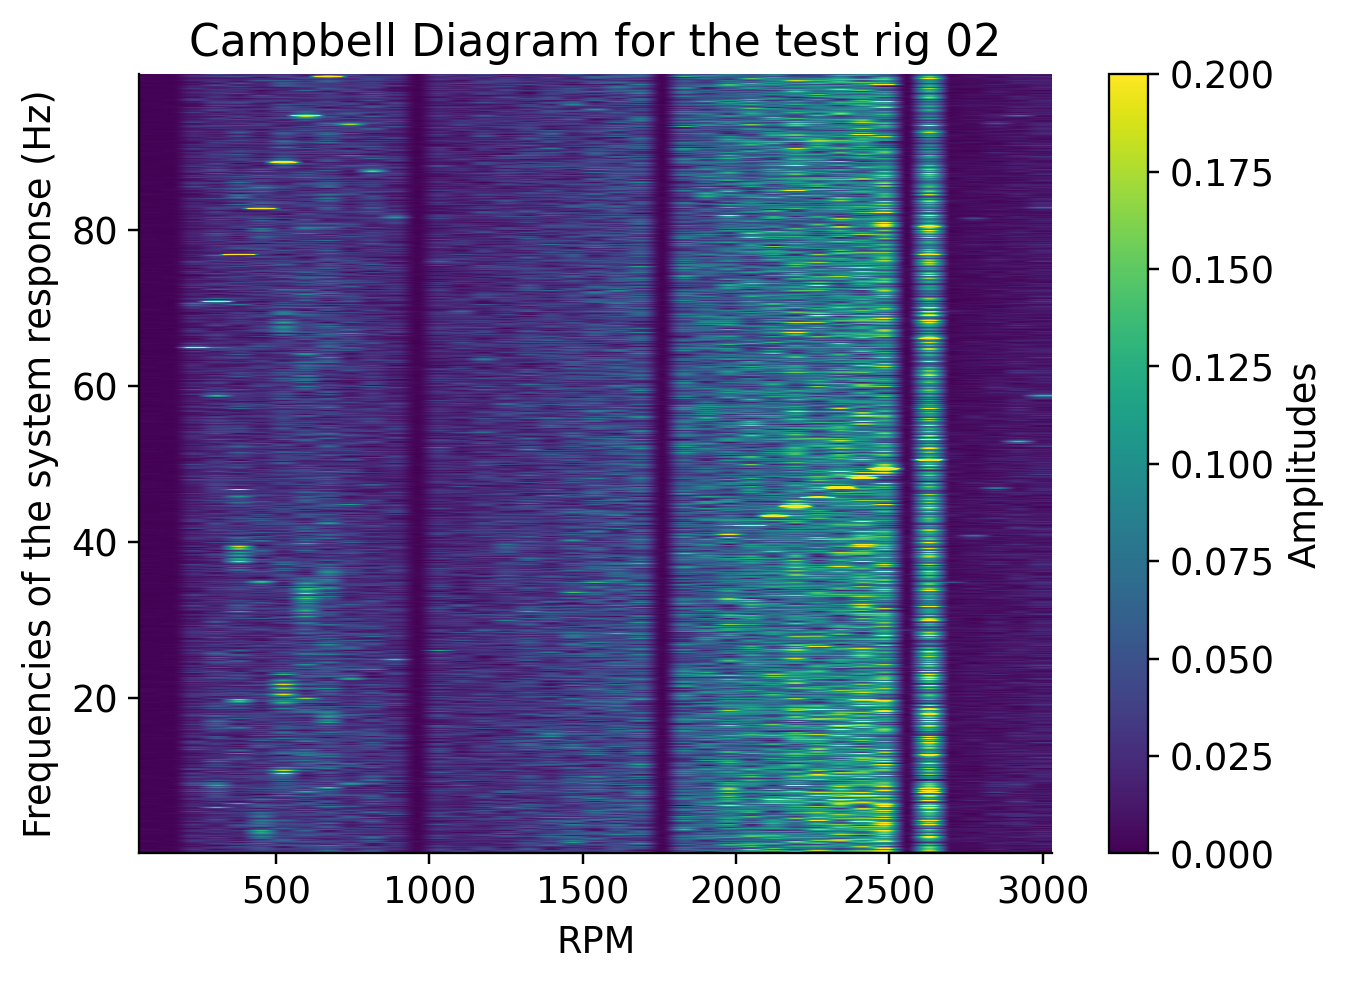

In [10]:
# create the Heatmap (Campbell-Diagramm)
plt.imshow(np.transpose(amplitude_fft), extent=[np.min(rpm), np.max(rpm), np.min(frequency_fft), np.max(frequency_fft)],
           aspect='auto', cmap='viridis', origin='lower', vmin=0, vmax=0.2)
plt.colorbar(label='Amplitudes')
plt.xlabel('RPM')
plt.ylabel('Frequencies of the system response (Hz)')
plt.title('Campbell Diagram for the test rig 02')
plt.show()

## Dritter Datensatz: Prüfstand #04

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", 'data_20240109_104244_lavalrotor_01_04'
)  # path to the folder with H5-file and metadata
filename = 'data_20240109_104244_lavalrotor_01_04.h5'  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions

time = []
rpm = []
amplitude_fft =[]
frequency_fft = []

# path to the h5 data
h5_path = f"{path_measurement_folder}/{filename}"

# Loop to read out the data
with h5py.File(h5_path) as f:
    for i in f.keys():
        group_h5 = f[i]["RawData"]

        acc_x_value = np.array(group_h5[uuid_acceleration]["acceleration_x"])
        acc_y_value= np.array(group_h5[uuid_acceleration]["acceleration_y"])
        acc_z_value = np.array(group_h5[uuid_acceleration]["acceleration_z"])
        time_value = np.array(group_h5[uuid_acceleration]["timestamp"])
        time.append(time_value)
        rpm_value = group_h5[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_value)

        # calculate the absolute acceleration
        acc_data_value = m_postprocessing.get_vec_accel(acc_x_value, acc_y_value, acc_z_value)

        # interpolate the acceleration data to get the amplitudes and frequencies
        interpolated_acc_data_value = m_postprocessing.interpolation(time_value, acc_data_value, interpolation_points)
        amplitude_fft_value, frequency_fft_value = m_postprocessing.my_fft_scaled(interpolated_acc_data_value, interpolation_points)
        amplitude_fft.append(amplitude_fft_value[1:])
        frequency_fft.append(frequency_fft_value[1:])

#print(amplitude_fft)

#### 3. Darstellung mittels Campbell-Diagramm

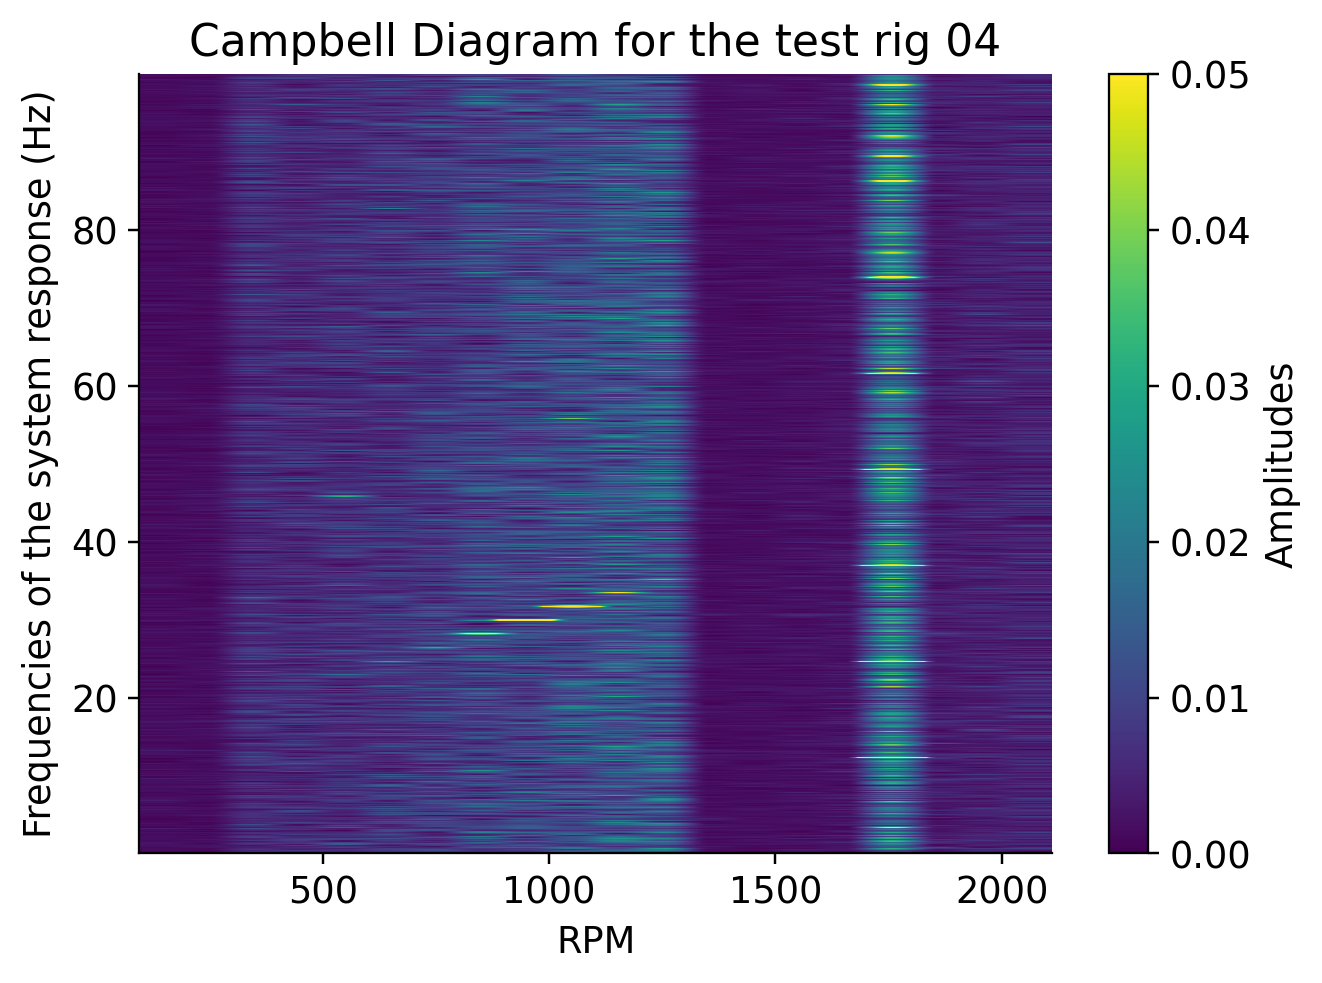

In [13]:
# create the Heatmap (Campbell-Diagramm)
plt.imshow(np.transpose(amplitude_fft), extent=[np.min(rpm), np.max(rpm), np.min(frequency_fft), np.max(frequency_fft)],
           aspect='auto', cmap='viridis', origin='lower', vmin=0, vmax=0.05)
plt.colorbar(label='Amplitudes')
plt.xlabel('RPM')
plt.ylabel('Frequencies of the system response (Hz)')
plt.title('Campbell Diagram for the test rig 04')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Anhand der einzelnen Campbell-Diagramme ist zu erkennen, dass die einzelnen Prüfstände unterschiedliche rotordynamische Stabilitäten bei unterschiedlichen Drehzahlen besitzen. So besitzt der Prüfstand 03 bei relativ hohen Drehzahlen stabile Bereiche mit geringen Amplituden, was auch zu den Beobachtungen während des Versuchs passt, da nach aufgetretenen Vibrationen des Prüfstandes bei ca. 1000 rpm , anschließend bei ca. 2000 rpm die Vibrationen des Prüfstandes aufgehört haben und sich dieser wieder selbst zentriert hat. Bei den anderen Testständen sieht man anhnd der Campbell-Diagramme, dass diese stabilen Betreibsbereiche ohne starke Schwingung des Prüfstandes bei etwas anderen Stellen zu sehen sind. Der Prüfstand 02 weist die geringsten Betiebsbereiche der einzelnen Teststände auf.

Die kritischen Bereiche zeichnen sich durch erhöhte Amplituden aus und befinden sich  bei den unterschiedlichen Prüfständen an folgenden Stellen bei den jeweiligen Drehzahlen:

kritische Betriebsbereiche:

- Prüfstand 03: 400 bis 1900 rpm
- Prüfstand 02: 100 bis 2700 rpm
- Prüfstand 04: 200 bis 1600 rpm und bei 1750 rpm

Anhad der Messdaten ist zu erkennen, dass sich die Rotoren nach einem kritischen Bereich wieder selbst zentrieren, da dort dann keine hohen Amplituden im Campbell-Diagarmm zu sehen sind und es sich somit um einen nicht kritischen Betriebsbereich handelt. Dies kann man sehr schön an dem Campbell-Diagramm des Testandes 02 sehen. Hier sieht man nicht kritische Betriebsbereiche bei den Drehzahlen um 950 rpm, 1750 rpm und 2550 rpm, sowie nach und vor dem kritischen Bereichen, die oben gennant wurden. Diese Bereiche zeigen dann auch genau die Drehzahlen, bei denen sich die Rotoren selbst zentrieren.

Diese ganzen Beobachtungen und Auswertungen können auf die veränderten Versuchsaufbauten zurückzuführen seien. Anhand der einzelnen Metadaten ist zu erkennen, dass sich zum Beispiel die Masse der Scheibe zwischen den Testständen variiert hat (Testand 03: 950 g, Testand 02: 500 g, Teststand 04: 1000 g) und dies somit zu veränderten kritischen Drehzahlen führt, die sich dann in den Campbell-Diagrammen wiederspiegeln.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Für die analytische Berechnung der Drehzahl wurde als erstes die kritische Kreisfrequenz berechnet. Diese wurde mithilfe der Masse der Scheibe, der Ersatzfedersteifigkeit und der Abstandsverhältnisse zwischen der Scheibe und den Lagern zu 111,11 [1/s] berechnet. Anschließend wurde hiermit die kritische Drehzahl bestimmt zu 1061,04 [1/min]. Anhand des Campbell-Diagarmms ist zu erkennen, dass die analytisch berechnete kritische Drehzahl innerhalb des kritischen Bereichs im Campbell-Diagramm befindet. Zudem sieht man, dass die Gerade der Anregungsfrequenz, als sie die analytisch berechnete kritische Drehzahl schneidet, eine erhöhte Amplitude aufweist, wie auch hier in diesem Bild zu sehen ist:

<img src="figures/Campbell-Diagramm_Analyse.jpg" width="800">

Somit stimmen die gemessene und die analytisch bestimmte kritische Drehzahl bei dem Prüfstand 03 ungefähr überein. Dies passt auch zu den wahrgenommenen Vibrationen während des Versuchs, diese traten ebenfalls ungefähr ab 1000 Umdrehungen pro Minute auf.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Bei diesem Versuch war es sehr interessnat zu sehen, wie der Versuch im Vergleich zu dem Versuch Zuhause aufgebaut war. Zudem war sehr interessant, dass man anhand der Campbell-Diagramme wirklich die Schwingungen/ Vibrationen, die man vor Ort wahrnehmen konnte an den jeweiligen Stellen im Diagramm sehen konnte. Ich kann mir vorstellen, dass die Analyse des Campbell-Diagramms noch weiterhin eine wichtige Rolle spielen wird, vor allem wenn man zum Beispiel die Schwingungen an Windkraftanlagen durch Unwucht bestimmen muss oder bei anderen praktischen Anwendungen.